<a href="https://colab.research.google.com/github/rodrigo1489/CG-SpaceInvaders/blob/main/Trabalho_1_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lido: /content/winequality-red.csv | shape: (1599, 12)
[BINARY] Positivos: 217 | Negativos: 1382
Baseline acc: 0.866
Class weights: {0: 0.5784077201447527, 1: 3.6884615384615387}
Épocas (binary): 50


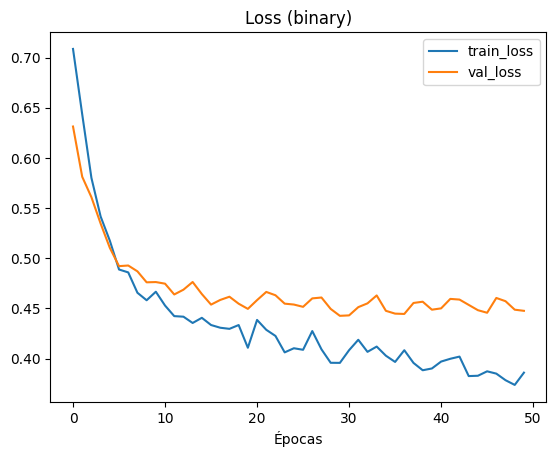

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

[Binary] Confusion Matrix (0.5):
 [[234  43]
 [  5  38]]

[Binary] Classification Report (0.5):
               precision    recall  f1-score   support

           0      0.979     0.845     0.907       277
           1      0.469     0.884     0.613        43

    accuracy                          0.850       320
   macro avg      0.724     0.864     0.760       320
weighted avg      0.911     0.850     0.867       320

[Binary] AUC ROC: 0.9011837796994375


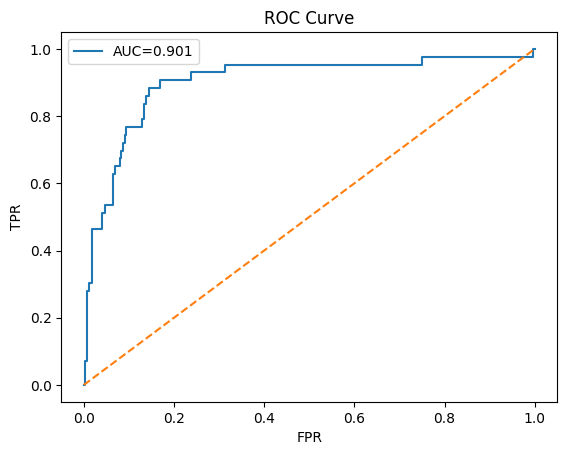

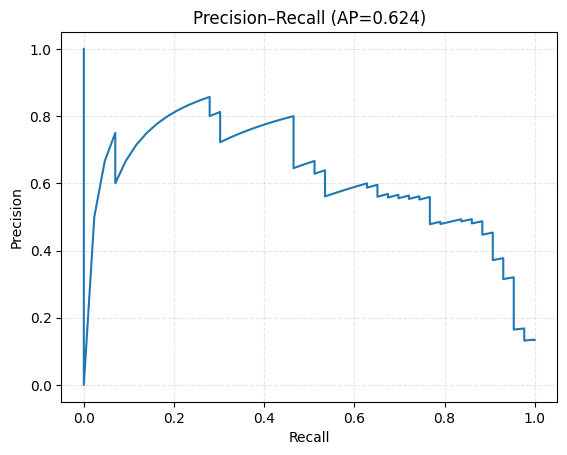

[Binary] Threshold ótimo (F1+): 0.638 | F1_max=0.647

[Binary] Confusion Matrix (thr ótimo):
 [[250  27]
 [ 10  33]]

[Binary] Classification Report (thr ótimo):
               precision    recall  f1-score   support

           0      0.962     0.903     0.931       277
           1      0.550     0.767     0.641        43

    accuracy                          0.884       320
   macro avg      0.756     0.835     0.786       320
weighted avg      0.906     0.884     0.892       320


Ficheiros: wine_model_binary.keras, scaler.pkl, predictions_binary.csv, model_meta.json
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 1: AUC=0.881 | AP=0.525 | F1@0.5=0.511 | F1@opt=0.584 @thr≈0.802
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2: AUC=0.880 | AP=0.541 | F1@0.5=0.540 | F1@opt=0.640 @thr≈0.732
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3: AUC=0.897 | AP=0.581 | F1@0.5=0.537 | F1@opt=0.614 @thr≈0.720
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 4: AUC=0.831 | AP=0.429 | F1@0.5=0.490 | F1@op

In [2]:
# ============================================
# 1) FLAGS
# ============================================
TASK_TYPE = 'binary'      # 'binary' | 'multiclass' | 'regression'
DATASET   = 'red'         # 'red' | 'white'

# ============================================
# 2) Imports & seeds
# ============================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, average_precision_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import joblib

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 3) Download automático do dataset UCI
# ============================================
LOCAL   = f'/content/winequality-{DATASET}.csv'
UCI_URL = f'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{DATASET}.csv'
if not os.path.exists(LOCAL):
    !wget -q -O "$LOCAL" "$UCI_URL"

df = pd.read_csv(LOCAL, sep=';')
print("Lido:", LOCAL, "| shape:", df.shape)

# ============================================
# 4) Preparação do alvo conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    # alvo: qualidade >=7
    df['target'] = (df['quality'] >= 7).astype(int)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    print(f"[BINARY] Positivos: {int(y.sum())} | Negativos: {int((y==0).sum())}")
elif TASK_TYPE == 'multiclass':
    # alvo 3 classes: ≤5, 6, ≥7
    def to_bucket(q):
        if q <= 5: return 0
        if q == 6: return 1
        return 2
    df['target'] = df['quality'].apply(to_bucket)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    classes, counts = np.unique(y, return_counts=True)
    print(f"[MULTICLASS] Dist: {dict(zip(classes, counts))}  (0=≤5, 1=6, 2=≥7)")
elif TASK_TYPE == 'regression':
    y = df['quality'].values.astype(float)
    X = df.drop(columns=['quality']).values
    print(f"[REGRESSION] y range: {y.min()}..{y.max()}")
else:
    raise ValueError("TASK_TYPE inválido")

# Split (hold-out)
test_size = 0.40
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=test_size, random_state=42,
    stratify=y if TASK_TYPE != 'regression' else None
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42,
    stratify=y_temp if TASK_TYPE != 'regression' else None
)

# Baseline
if TASK_TYPE in ['binary','multiclass']:
    base = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
    print(f"Baseline acc: {base.score(X_test, y_test):.3f}")
else:
    base = DummyRegressor(strategy="mean").fit(X_train, y_train)
    yb = base.predict(X_test)
    print(f"Baseline RMSE (mean): {mean_squared_error(y_test, yb, squared=False):.3f}")

# Normalização
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Class weights (para classificações)
CLASS_WEIGHTS = None
if TASK_TYPE in ['binary','multiclass']:
    classes = np.unique(y_train)
    cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_vals)}
    print("Class weights:", CLASS_WEIGHTS)

# ============================================
# 5) Model builders
# ============================================
def build_binary_model(input_dim, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return m

def build_multiclass_model(input_dim, n_classes=3, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_regression_model(input_dim, l2=1e-4, drop=0.10, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='mse',
              metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return m

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ============================================
# 6) Treinar conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    model = build_binary_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (binary): {len(hist.history['loss'])}")
elif TASK_TYPE == 'multiclass':
    model = build_multiclass_model(X_train.shape[1], n_classes=len(np.unique(y)))
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (multi): {len(hist.history['loss'])}")
else:
    model = build_regression_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64, callbacks=[early_stop], verbose=0)
    print(f"Épocas (reg): {len(hist.history['loss'])}")

# Curvas de treino (loss)
plt.figure()
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title(f'Loss ({TASK_TYPE})'); plt.xlabel('Épocas'); plt.legend(); plt.show()

# ============================================
# 7) Avaliação por modo
# ============================================
feature_names = df.drop(columns=['quality'] + (['target'] if 'target' in df.columns else [])).columns.tolist()

if TASK_TYPE == 'binary':
    probs = model.predict(X_test).ravel()
    pred05 = (probs >= 0.5).astype(int)
    print("\n[Binary] Confusion Matrix (0.5):\n", confusion_matrix(y_test, pred05))
    print("\n[Binary] Classification Report (0.5):\n", classification_report(y_test, pred05, digits=3))
    print("[Binary] AUC ROC:", roc_auc_score(y_test, probs))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()

    # PR + threshold ótimo por F1(+)
    prec, rec, thr = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    f1_curve = (2*prec*rec)/(prec+rec+1e-12)
    best_idx = int(np.argmax(f1_curve))
    best_thr = thr[best_idx-1] if best_idx>0 else 0.5

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall (AP={ap:.3f})")
    plt.grid(True, ls='--', alpha=0.3); plt.show()

    print(f"[Binary] Threshold ótimo (F1+): {best_thr:.3f} | F1_max={f1_curve[best_idx]:.3f}")
    pred_opt = (probs >= best_thr).astype(int)
    print("\n[Binary] Confusion Matrix (thr ótimo):\n", confusion_matrix(y_test, pred_opt))
    print("\n[Binary] Classification Report (thr ótimo):\n", classification_report(y_test, pred_opt, digits=3))

    # Guardar artefactos + meta
    model.save('wine_model_binary.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_prob': probs,
                  'y_pred_0p5': pred05, 'y_pred_opt': pred_opt}).to_csv('predictions_binary.csv', index=False)
    meta = {"task":"binary","best_threshold":float(best_thr),"feature_names":feature_names,
            "model_path":"wine_model_binary.keras","scaler_path":"scaler.pkl",
            "dataset":{"name":f"winequality-{DATASET}","n_features":len(feature_names)}}
    with open("model_meta.json","w") as f: json.dump(meta,f,indent=2)
    print("\nFicheiros: wine_model_binary.keras, scaler.pkl, predictions_binary.csv, model_meta.json")

elif TASK_TYPE == 'multiclass':
    probs = model.predict(X_test)     # shape (n, 3)
    y_pred = probs.argmax(axis=1)
    print("\n[Multiclass] Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n[Multiclass] Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    # ROC AUC (ovo) opcional
    try:
        auc_ovr = roc_auc_score(y_test, probs, multi_class='ovr')
        print("[Multiclass] ROC AUC (OvR):", round(auc_ovr,3))
    except Exception as e:
        print("[Multiclass] ROC AUC (OvR) indisponível:", e)

    # Guardar
    model.save('wine_model_multiclass.keras')
    joblib.dump(scaler, 'scaler.pkl')
    out = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    for k in range(probs.shape[1]): out[f'p_class{k}'] = probs[:,k]
    out.to_csv('predictions_multiclass.csv', index=False)
    print("\nFicheiros: wine_model_multiclass.keras, scaler.pkl, predictions_multiclass.csv")

else:  # regression
    y_pred = model.predict(X_test).ravel()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"\n[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

    # Parity plot
    plt.figure()
    plt.scatter(y_test, y_pred, s=18, alpha=0.7)
    lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
    plt.plot(lims, lims, '--'); plt.xlim(lims); plt.ylim(lims)
    plt.xlabel('True quality'); plt.ylabel('Predicted quality'); plt.title('Parity plot'); plt.show()

    # Guardar
    model.save('wine_model_regression.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv('predictions_regression.csv', index=False)
    print("\nFicheiros: wine_model_regression.keras, scaler.pkl, predictions_regression.csv")

# ============================================
# 8) (Opcional) K-Fold apenas para 'binary' (robustez)
# ============================================
def kfold_binary(X_all, y_all, k=5, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    aucs, aps, f1_05, f1_opt = [], [], [], []
    for fold, (tr, te) in enumerate(skf.split(X_all, y_all), 1):
        X_tr, X_te = X_all[tr], X_all[te]; y_tr, y_te = y_all[tr], y_all[te]
        sc = StandardScaler().fit(X_tr)
        X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)
        classes = np.unique(y_tr)
        cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
        cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
        m = build_binary_model(X_tr.shape[1])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
              class_weight=cw, callbacks=[es], verbose=0)
        p = m.predict(X_te).ravel()
        yhat05 = (p>=0.5).astype(int)
        aucs.append(roc_auc_score(y_te, p))
        aps.append(average_precision_score(y_te, p))
        prec, rec, thr = precision_recall_curve(y_te, p)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (p>=thr_opt).astype(int)
        f1_05.append(f1_score(y_te, yhat05, pos_label=1))
        f1_opt.append(f1_score(y_te, yhat_opt, pos_label=1))
        print(f"Fold {fold}: AUC={aucs[-1]:.3f} | AP={aps[-1]:.3f} | F1@0.5={f1_05[-1]:.3f} | F1@opt={f1_opt[-1]:.3f} @thr≈{thr_opt:.3f}")
    s=lambda v: f"{np.mean(v):.3f} ± {np.std(v):.3f}"
    print("\n== K-Fold Binary (média ± dp) ==")
    print("AUC ROC :", s(aucs))
    print("AUC-PR  :", s(aps))
    print("F1 @0.5 :", s(f1_05))
    print("F1 @opt :", s(f1_opt))

# Para correr K-Fold
if TASK_TYPE == 'binary':
     X_all = df.drop(columns=['quality','target']).values
     y_all = df['target'].values
     kfold_binary(X_all, y_all, k=5)

# ============================================================
# 9) EXTRA: SMOTE + Comparativos + Repeated K-Fold (5×3)  [BINARY ONLY]
# ============================================================
if TASK_TYPE != 'binary':
    print("\n[Extra SMOTE/Comparativos/Repeated K-Fold] — ignorado (TASK_TYPE != 'binary').")
else:
    # ---------- Setup & utils ----------
    from sklearn.metrics import (classification_report, roc_auc_score,
                                 average_precision_score, precision_recall_curve, f1_score)
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.preprocessing import StandardScaler

    try:
        from imblearn.over_sampling import SMOTE
    except Exception:
        !pip install -q imbalanced-learn
        from imblearn.over_sampling import SMOTE

    def summarize_binary(y_true, probs, name="Model"):
        """AUC, AP, F1@0.5, F1@opt."""
        auc_roc = roc_auc_score(y_true, probs)
        ap      = average_precision_score(y_true, probs)
        yhat05  = (probs >= 0.5).astype(int)
        prec, rec, thr = precision_recall_curve(y_true, probs)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (probs >= thr_opt).astype(int)
        f1_05  = f1_score(y_true, yhat05,  pos_label=1)
        f1_opt = f1_score(y_true, yhat_opt, pos_label=1)
        print(f"\n== {name} ==")
        print(f"AUC ROC : {auc_roc:.3f}")
        print(f"AUC-PR  : {ap:.3f}")
        print(f"F1 @0.5 : {f1_05:.3f}")
        print(f"F1 @opt : {f1_opt:.3f}  @thr≈{thr_opt:.3f}")
        return {"auc":auc_roc, "ap":ap, "f1_05":f1_05, "f1_opt":f1_opt, "thr_opt":thr_opt}

    # 1) MLP com SMOTE (oversampling só no treino)
    sm = SMOTE(random_state=42)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)
    model_smote = build_binary_model(X_tr_sm.shape[1])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history_sm = model_smote.fit(
        X_tr_sm, y_tr_sm, validation_data=(X_val, y_val),
        epochs=300, batch_size=64, callbacks=[es], verbose=0
    )
    probs_sm = model_smote.predict(X_test).ravel()
    _ = summarize_binary(y_test, probs_sm, name="MLP (SMOTE)")

    # 2) Clássicos: Logistic Regression & Random Forest
    # (a) Com class_weight='balanced'
    logit_w = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
    rf_w    = RandomForestClassifier(n_estimators=400, random_state=42,
                                     class_weight='balanced_subsample', n_jobs=-1)
    logit_w.fit(X_train, y_train)
    rf_w.fit(X_train, y_train)
    p_logit_w = logit_w.predict_proba(X_test)[:,1]
    p_rf_w    = rf_w.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_w, name="LogReg (class_weight)")
    _ = summarize_binary(y_test, p_rf_w,    name="RandomForest (class_weight)")

    # (b) SMOTE nos clássicos
    X_tr_sm2, y_tr_sm2 = sm.fit_resample(X_train, y_train)
    logit_sm = LogisticRegression(max_iter=2000, solver='liblinear')
    rf_sm    = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    logit_sm.fit(X_tr_sm2, y_tr_sm2)
    rf_sm.fit(X_tr_sm2, y_tr_sm2)
    p_logit_sm = logit_sm.predict_proba(X_test)[:,1]
    p_rf_sm    = rf_sm.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_sm, name="LogReg (SMOTE)")
    _ = summarize_binary(y_test, p_rf_sm,    name="RandomForest (SMOTE)")

    # 3) Repeated Stratified K-Fold (5×3) — MLP vs LogReg vs RF (com e sem SMOTE)
    def repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42):
        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
        stats = {"MLP": {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "LogReg":{"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "RF":    {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]}}
        for fold, (tr, te) in enumerate(rskf.split(X_all, y_all), 1):
            X_tr, X_te = X_all[tr], X_all[te];  y_tr, y_te = y_all[tr], y_all[te]
            sc = StandardScaler().fit(X_tr)
            X_tr = sc.transform(X_tr); X_te = sc.transform(X_te)
            if use_smote:
                X_tr, y_tr = SMOTE(random_state=seed).fit_resample(X_tr, y_tr)
                cw = None
                logit = LogisticRegression(max_iter=2000, solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed, n_jobs=-1)
            else:
                classes = np.unique(y_tr)
                cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
                cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
                logit = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed,
                                               class_weight='balanced_subsample', n_jobs=-1)
            # MLP
            m = build_binary_model(X_tr.shape[1])
            es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
                  class_weight=cw, callbacks=[es], verbose=0)
            p_m = m.predict(X_te).ravel()
            # LogReg
            logit.fit(X_tr, y_tr); p_l = logit.predict_proba(X_te)[:,1]
            # RF
            rf.fit(X_tr, y_tr);    p_r = rf.predict_proba(X_te)[:,1]

            def add_stats(name, probs):
                auc_  = roc_auc_score(y_te, probs)
                ap_   = average_precision_score(y_te, probs)
                y05   = (probs>=0.5).astype(int)
                prec, rec, thr = precision_recall_curve(y_te, probs)
                f1c = (2*prec*rec)/(prec+rec+1e-12)
                idx = int(np.argmax(f1c))
                thr_opt = thr[idx-1] if idx>0 else 0.5
                yopt = (probs>=thr_opt).astype(int)
                stats[name]["auc"].append(auc_)
                stats[name]["ap"].append(ap_)
                stats[name]["f1_05"].append(f1_score(y_te, y05,  pos_label=1))
                stats[name]["f1_opt"].append(f1_score(y_te, yopt, pos_label=1))
            add_stats("MLP", p_m); add_stats("LogReg", p_l); add_stats("RF", p_r)

        def s(v): return f"{np.mean(v):.3f} ± {np.std(v):.3f}"
        print("\n" + ("="*64))
        print("Repeated Stratified K-Fold " + ("(SMOTE on train)" if use_smote else "(class_weight)"))
        print("="*64)
        for name in ["MLP","LogReg","RF"]:
            print(f"\n[{name}]  AUC={s(stats[name]['auc'])} | AP={s(stats[name]['ap'])} | "
                  f"F1@0.5={s(stats[name]['f1_05'])} | F1@opt={s(stats[name]['f1_opt'])}")
        return stats

    X_all = df.drop(columns=['quality','target']).values
    y_all = df['target'].values
    stats_weights = repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42)
    stats_smote   = repeated_cv_binary(X_all, y_all, use_smote=True,  n_splits=5, n_repeats=3, seed=42)

    print("\n✅ Fim dos comparativos: tens MLP (normal/SMOTE), LogReg e RF — com e sem SMOTE — "
          "avaliados em Hold-out e em Repeated K-Fold (média ± dp).")


Lido: /content/winequality-red.csv | shape: (1599, 12)
[MULTICLASS] Dist: {np.int64(0): np.int64(744), np.int64(1): np.int64(638), np.int64(2): np.int64(217)}  (0=≤5, 1=6, 2=≥7)
Baseline acc: 0.466
Class weights: {0: 0.7167414050822123, 1: 0.834638816362054, 2: 2.458974358974359}
Épocas (multi): 53


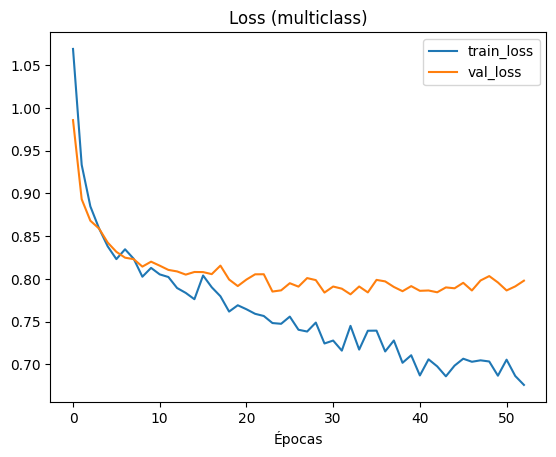

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

[Multiclass] Confusion Matrix:
 [[110  33   6]
 [ 38  54  36]
 [  1  11  31]]

[Multiclass] Classification Report:
               precision    recall  f1-score   support

           0      0.738     0.738     0.738       149
           1      0.551     0.422     0.478       128
           2      0.425     0.721     0.534        43

    accuracy                          0.609       320
   macro avg      0.571     0.627     0.584       320
weighted avg      0.621     0.609     0.607       320

[Multiclass] ROC AUC (OvR): 0.821

Ficheiros: wine_model_multiclass.keras, scaler.pkl, predictions_multiclass.csv

[Extra SMOTE/Comparativos/Repeated K-Fold] — ignorado (TASK_TYPE != 'binary').


In [5]:
# ============================================
# 1) FLAGS
# ============================================
TASK_TYPE = 'multiclass'      # 'binary' | 'multiclass' | 'regression'
DATASET   = 'red'         # 'red' | 'white'

# ============================================
# 2) Imports & seeds
# ============================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, average_precision_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import joblib

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 3) Download automático do dataset UCI
# ============================================
LOCAL   = f'/content/winequality-{DATASET}.csv'
UCI_URL = f'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{DATASET}.csv'
if not os.path.exists(LOCAL):
    !wget -q -O "$LOCAL" "$UCI_URL"

df = pd.read_csv(LOCAL, sep=';')
print("Lido:", LOCAL, "| shape:", df.shape)

# ============================================
# 4) Preparação do alvo conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    # alvo: qualidade >=7
    df['target'] = (df['quality'] >= 7).astype(int)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    print(f"[BINARY] Positivos: {int(y.sum())} | Negativos: {int((y==0).sum())}")
elif TASK_TYPE == 'multiclass':
    # alvo 3 classes: ≤5, 6, ≥7
    def to_bucket(q):
        if q <= 5: return 0
        if q == 6: return 1
        return 2
    df['target'] = df['quality'].apply(to_bucket)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    classes, counts = np.unique(y, return_counts=True)
    print(f"[MULTICLASS] Dist: {dict(zip(classes, counts))}  (0=≤5, 1=6, 2=≥7)")
elif TASK_TYPE == 'regression':
    y = df['quality'].values.astype(float)
    X = df.drop(columns=['quality']).values
    print(f"[REGRESSION] y range: {y.min()}..{y.max()}")
else:
    raise ValueError("TASK_TYPE inválido")

# Split (hold-out)
test_size = 0.40
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=test_size, random_state=42,
    stratify=y if TASK_TYPE != 'regression' else None
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42,
    stratify=y_temp if TASK_TYPE != 'regression' else None
)

# Baseline
if TASK_TYPE in ['binary','multiclass']:
    base = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
    print(f"Baseline acc: {base.score(X_test, y_test):.3f}")
else:
    base = DummyRegressor(strategy="mean").fit(X_train, y_train)
    yb = base.predict(X_test)
    print(f"Baseline RMSE (mean): {mean_squared_error(y_test, yb, squared=False):.3f}")

# Normalização
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Class weights (para classificações)
CLASS_WEIGHTS = None
if TASK_TYPE in ['binary','multiclass']:
    classes = np.unique(y_train)
    cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_vals)}
    print("Class weights:", CLASS_WEIGHTS)

# ============================================
# 5) Model builders
# ============================================
def build_binary_model(input_dim, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return m

def build_multiclass_model(input_dim, n_classes=3, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_regression_model(input_dim, l2=1e-4, drop=0.10, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='mse',
              metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return m

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ============================================
# 6) Treinar conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    model = build_binary_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (binary): {len(hist.history['loss'])}")
elif TASK_TYPE == 'multiclass':
    model = build_multiclass_model(X_train.shape[1], n_classes=len(np.unique(y)))
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (multi): {len(hist.history['loss'])}")
else:
    model = build_regression_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64, callbacks=[early_stop], verbose=0)
    print(f"Épocas (reg): {len(hist.history['loss'])}")

# Curvas de treino (loss)
plt.figure()
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title(f'Loss ({TASK_TYPE})'); plt.xlabel('Épocas'); plt.legend(); plt.show()

# ============================================
# 7) Avaliação por modo
# ============================================
feature_names = df.drop(columns=['quality'] + (['target'] if 'target' in df.columns else [])).columns.tolist()

if TASK_TYPE == 'binary':
    probs = model.predict(X_test).ravel()
    pred05 = (probs >= 0.5).astype(int)
    print("\n[Binary] Confusion Matrix (0.5):\n", confusion_matrix(y_test, pred05))
    print("\n[Binary] Classification Report (0.5):\n", classification_report(y_test, pred05, digits=3))
    print("[Binary] AUC ROC:", roc_auc_score(y_test, probs))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()

    # PR + threshold ótimo por F1(+)
    prec, rec, thr = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    f1_curve = (2*prec*rec)/(prec+rec+1e-12)
    best_idx = int(np.argmax(f1_curve))
    best_thr = thr[best_idx-1] if best_idx>0 else 0.5

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall (AP={ap:.3f})")
    plt.grid(True, ls='--', alpha=0.3); plt.show()

    print(f"[Binary] Threshold ótimo (F1+): {best_thr:.3f} | F1_max={f1_curve[best_idx]:.3f}")
    pred_opt = (probs >= best_thr).astype(int)
    print("\n[Binary] Confusion Matrix (thr ótimo):\n", confusion_matrix(y_test, pred_opt))
    print("\n[Binary] Classification Report (thr ótimo):\n", classification_report(y_test, pred_opt, digits=3))

    # Guardar artefactos + meta
    model.save('wine_model_binary.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_prob': probs,
                  'y_pred_0p5': pred05, 'y_pred_opt': pred_opt}).to_csv('predictions_binary.csv', index=False)
    meta = {"task":"binary","best_threshold":float(best_thr),"feature_names":feature_names,
            "model_path":"wine_model_binary.keras","scaler_path":"scaler.pkl",
            "dataset":{"name":f"winequality-{DATASET}","n_features":len(feature_names)}}
    with open("model_meta.json","w") as f: json.dump(meta,f,indent=2)
    print("\nFicheiros: wine_model_binary.keras, scaler.pkl, predictions_binary.csv, model_meta.json")

elif TASK_TYPE == 'multiclass':
    probs = model.predict(X_test)     # shape (n, 3)
    y_pred = probs.argmax(axis=1)
    print("\n[Multiclass] Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n[Multiclass] Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    # ROC AUC (ovo) opcional
    try:
        auc_ovr = roc_auc_score(y_test, probs, multi_class='ovr')
        print("[Multiclass] ROC AUC (OvR):", round(auc_ovr,3))
    except Exception as e:
        print("[Multiclass] ROC AUC (OvR) indisponível:", e)

    # Guardar
    model.save('wine_model_multiclass.keras')
    joblib.dump(scaler, 'scaler.pkl')
    out = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    for k in range(probs.shape[1]): out[f'p_class{k}'] = probs[:,k]
    out.to_csv('predictions_multiclass.csv', index=False)
    print("\nFicheiros: wine_model_multiclass.keras, scaler.pkl, predictions_multiclass.csv")

else:  # regression
    y_pred = model.predict(X_test).ravel()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"\n[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

    # Parity plot
    plt.figure()
    plt.scatter(y_test, y_pred, s=18, alpha=0.7)
    lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
    plt.plot(lims, lims, '--'); plt.xlim(lims); plt.ylim(lims)
    plt.xlabel('True quality'); plt.ylabel('Predicted quality'); plt.title('Parity plot'); plt.show()

    # Guardar
    model.save('wine_model_regression.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv('predictions_regression.csv', index=False)
    print("\nFicheiros: wine_model_regression.keras, scaler.pkl, predictions_regression.csv")

# ============================================
# 8) (Opcional) K-Fold apenas para 'binary' (robustez)
# ============================================
def kfold_binary(X_all, y_all, k=5, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    aucs, aps, f1_05, f1_opt = [], [], [], []
    for fold, (tr, te) in enumerate(skf.split(X_all, y_all), 1):
        X_tr, X_te = X_all[tr], X_all[te]; y_tr, y_te = y_all[tr], y_all[te]
        sc = StandardScaler().fit(X_tr)
        X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)
        classes = np.unique(y_tr)
        cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
        cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
        m = build_binary_model(X_tr.shape[1])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
              class_weight=cw, callbacks=[es], verbose=0)
        p = m.predict(X_te).ravel()
        yhat05 = (p>=0.5).astype(int)
        aucs.append(roc_auc_score(y_te, p))
        aps.append(average_precision_score(y_te, p))
        prec, rec, thr = precision_recall_curve(y_te, p)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (p>=thr_opt).astype(int)
        f1_05.append(f1_score(y_te, yhat05, pos_label=1))
        f1_opt.append(f1_score(y_te, yhat_opt, pos_label=1))
        print(f"Fold {fold}: AUC={aucs[-1]:.3f} | AP={aps[-1]:.3f} | F1@0.5={f1_05[-1]:.3f} | F1@opt={f1_opt[-1]:.3f} @thr≈{thr_opt:.3f}")
    s=lambda v: f"{np.mean(v):.3f} ± {np.std(v):.3f}"
    print("\n== K-Fold Binary (média ± dp) ==")
    print("AUC ROC :", s(aucs))
    print("AUC-PR  :", s(aps))
    print("F1 @0.5 :", s(f1_05))
    print("F1 @opt :", s(f1_opt))

# Para correr K-Fold
if TASK_TYPE == 'binary':
     X_all = df.drop(columns=['quality','target']).values
     y_all = df['target'].values
     kfold_binary(X_all, y_all, k=5)

# ============================================================
# 9) EXTRA: SMOTE + Comparativos + Repeated K-Fold (5×3)  [BINARY ONLY]
# ============================================================
if TASK_TYPE != 'binary':
    print("\n[Extra SMOTE/Comparativos/Repeated K-Fold] — ignorado (TASK_TYPE != 'binary').")
else:
    # ---------- Setup & utils ----------
    from sklearn.metrics import (classification_report, roc_auc_score,
                                 average_precision_score, precision_recall_curve, f1_score)
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.preprocessing import StandardScaler

    try:
        from imblearn.over_sampling import SMOTE
    except Exception:
        !pip install -q imbalanced-learn
        from imblearn.over_sampling import SMOTE

    def summarize_binary(y_true, probs, name="Model"):
        """AUC, AP, F1@0.5, F1@opt."""
        auc_roc = roc_auc_score(y_true, probs)
        ap      = average_precision_score(y_true, probs)
        yhat05  = (probs >= 0.5).astype(int)
        prec, rec, thr = precision_recall_curve(y_true, probs)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (probs >= thr_opt).astype(int)
        f1_05  = f1_score(y_true, yhat05,  pos_label=1)
        f1_opt = f1_score(y_true, yhat_opt, pos_label=1)
        print(f"\n== {name} ==")
        print(f"AUC ROC : {auc_roc:.3f}")
        print(f"AUC-PR  : {ap:.3f}")
        print(f"F1 @0.5 : {f1_05:.3f}")
        print(f"F1 @opt : {f1_opt:.3f}  @thr≈{thr_opt:.3f}")
        return {"auc":auc_roc, "ap":ap, "f1_05":f1_05, "f1_opt":f1_opt, "thr_opt":thr_opt}

    # 1) MLP com SMOTE (oversampling só no treino)
    sm = SMOTE(random_state=42)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)
    model_smote = build_binary_model(X_tr_sm.shape[1])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history_sm = model_smote.fit(
        X_tr_sm, y_tr_sm, validation_data=(X_val, y_val),
        epochs=300, batch_size=64, callbacks=[es], verbose=0
    )
    probs_sm = model_smote.predict(X_test).ravel()
    _ = summarize_binary(y_test, probs_sm, name="MLP (SMOTE)")

    # 2) Clássicos: Logistic Regression & Random Forest
    # (a) Com class_weight='balanced'
    logit_w = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
    rf_w    = RandomForestClassifier(n_estimators=400, random_state=42,
                                     class_weight='balanced_subsample', n_jobs=-1)
    logit_w.fit(X_train, y_train)
    rf_w.fit(X_train, y_train)
    p_logit_w = logit_w.predict_proba(X_test)[:,1]
    p_rf_w    = rf_w.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_w, name="LogReg (class_weight)")
    _ = summarize_binary(y_test, p_rf_w,    name="RandomForest (class_weight)")

    # (b) SMOTE nos clássicos
    X_tr_sm2, y_tr_sm2 = sm.fit_resample(X_train, y_train)
    logit_sm = LogisticRegression(max_iter=2000, solver='liblinear')
    rf_sm    = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    logit_sm.fit(X_tr_sm2, y_tr_sm2)
    rf_sm.fit(X_tr_sm2, y_tr_sm2)
    p_logit_sm = logit_sm.predict_proba(X_test)[:,1]
    p_rf_sm    = rf_sm.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_sm, name="LogReg (SMOTE)")
    _ = summarize_binary(y_test, p_rf_sm,    name="RandomForest (SMOTE)")

    # 3) Repeated Stratified K-Fold (5×3) — MLP vs LogReg vs RF (com e sem SMOTE)
    def repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42):
        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
        stats = {"MLP": {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "LogReg":{"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "RF":    {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]}}
        for fold, (tr, te) in enumerate(rskf.split(X_all, y_all), 1):
            X_tr, X_te = X_all[tr], X_all[te];  y_tr, y_te = y_all[tr], y_all[te]
            sc = StandardScaler().fit(X_tr)
            X_tr = sc.transform(X_tr); X_te = sc.transform(X_te)
            if use_smote:
                X_tr, y_tr = SMOTE(random_state=seed).fit_resample(X_tr, y_tr)
                cw = None
                logit = LogisticRegression(max_iter=2000, solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed, n_jobs=-1)
            else:
                classes = np.unique(y_tr)
                cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
                cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
                logit = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed,
                                               class_weight='balanced_subsample', n_jobs=-1)
            # MLP
            m = build_binary_model(X_tr.shape[1])
            es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
                  class_weight=cw, callbacks=[es], verbose=0)
            p_m = m.predict(X_te).ravel()
            # LogReg
            logit.fit(X_tr, y_tr); p_l = logit.predict_proba(X_te)[:,1]
            # RF
            rf.fit(X_tr, y_tr);    p_r = rf.predict_proba(X_te)[:,1]

            def add_stats(name, probs):
                auc_  = roc_auc_score(y_te, probs)
                ap_   = average_precision_score(y_te, probs)
                y05   = (probs>=0.5).astype(int)
                prec, rec, thr = precision_recall_curve(y_te, probs)
                f1c = (2*prec*rec)/(prec+rec+1e-12)
                idx = int(np.argmax(f1c))
                thr_opt = thr[idx-1] if idx>0 else 0.5
                yopt = (probs>=thr_opt).astype(int)
                stats[name]["auc"].append(auc_)
                stats[name]["ap"].append(ap_)
                stats[name]["f1_05"].append(f1_score(y_te, y05,  pos_label=1))
                stats[name]["f1_opt"].append(f1_score(y_te, yopt, pos_label=1))
            add_stats("MLP", p_m); add_stats("LogReg", p_l); add_stats("RF", p_r)

        def s(v): return f"{np.mean(v):.3f} ± {np.std(v):.3f}"
        print("\n" + ("="*64))
        print("Repeated Stratified K-Fold " + ("(SMOTE on train)" if use_smote else "(class_weight)"))
        print("="*64)
        for name in ["MLP","LogReg","RF"]:
            print(f"\n[{name}]  AUC={s(stats[name]['auc'])} | AP={s(stats[name]['ap'])} | "
                  f"F1@0.5={s(stats[name]['f1_05'])} | F1@opt={s(stats[name]['f1_opt'])}")
        return stats

    X_all = df.drop(columns=['quality','target']).values
    y_all = df['target'].values
    stats_weights = repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42)
    stats_smote   = repeated_cv_binary(X_all, y_all, use_smote=True,  n_splits=5, n_repeats=3, seed=42)

    print("\n✅ Fim dos comparativos: tens MLP (normal/SMOTE), LogReg e RF — com e sem SMOTE — "
          "avaliados em Hold-out e em Repeated K-Fold (média ± dp).")

Lido: /content/winequality-red.csv | shape: (1599, 12)
[REGRESSION] y range: 3.0..8.0
Baseline RMSE (mean): 0.841
Épocas (reg): 83


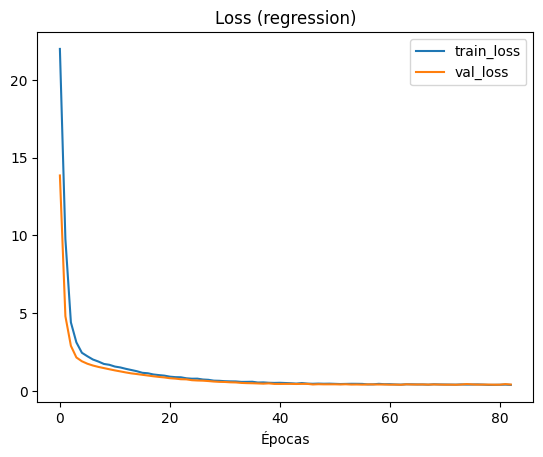

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

[Regression] RMSE=0.677 | MAE=0.534 | R²=0.351


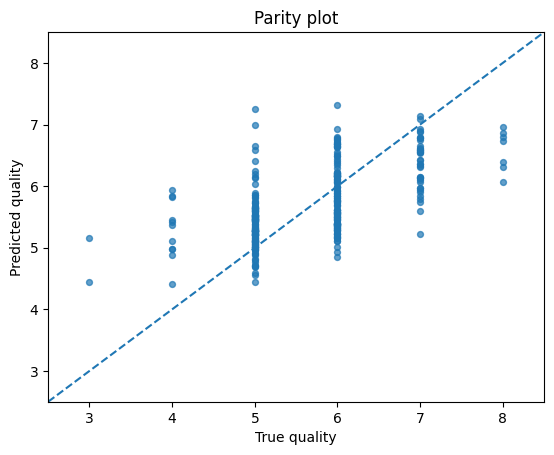

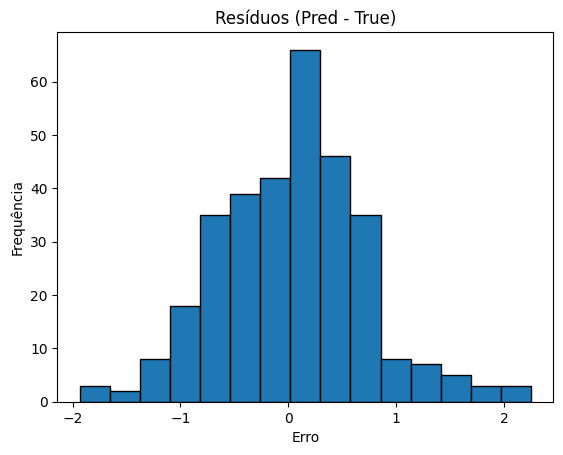


Ficheiros: wine_model_regression_red.keras, scaler_regression_red.pkl, predictions_regression_red.csv


In [7]:
# ============================================
# 0) FLAGS
# ============================================
TASK_TYPE = 'regression'    # 'binary' | 'multiclass' | 'regression'
DATASET   = 'red'           # 'red'| 'white'

# ============================================
# 1) Imports & seeds
# ============================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import joblib

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 2) Download automático do dataset UCI
# ============================================
LOCAL   = f'/content/winequality-{DATASET}.csv'
UCI_URL = f'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{DATASET}.csv'
if not os.path.exists(LOCAL):
    !wget -q -O "$LOCAL" "$UCI_URL"

df = pd.read_csv(LOCAL, sep=';')
print("Lido:", LOCAL, "| shape:", df.shape)

# ============================================
# 3) Preparação (REGRESSÃO)
# ============================================
y = df['quality'].values.astype(float)
X = df.drop(columns=['quality']).values
print(f"[REGRESSION] y range: {y.min()}..{y.max()}")

# Split Hold-out (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Baseline (RMSE = sqrt(MSE) — compatível com qualquer versão do sklearn)
base = DummyRegressor(strategy="mean").fit(X_train, y_train)
yb = base.predict(X_test)
rmse_base = (mean_squared_error(y_test, yb)) ** 0.5
print(f"Baseline RMSE (mean): {rmse_base:.3f}")

# Normalização
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ============================================
# 4) Modelo de Regressão (MLP)
# ============================================
def build_regression_model(input_dim, l2=1e-4, drop=0.10, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return m

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model = build_regression_model(X_train.shape[1])

# ============================================
# 5) Treino
# ============================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300, batch_size=64,
    callbacks=[early_stop], verbose=0
)
print(f"Épocas (reg): {len(history.history['loss'])}")

# Curva de loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss (regression)'); plt.xlabel('Épocas'); plt.legend(); plt.show()

# ============================================
# 6) Avaliação — Hold-out
# ============================================
y_pred = model.predict(X_test).ravel()
mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5                  # <- sem squared=False
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"\n[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

# Parity plot
plt.figure()
plt.scatter(y_test, y_pred, s=18, alpha=0.7)
lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
plt.plot(lims, lims, '--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel('True quality'); plt.ylabel('Predicted quality'); plt.title('Parity plot'); plt.show()

# Histograma de resíduos
resid = y_pred - y_test
plt.figure()
plt.hist(resid, bins=15, edgecolor='k')
plt.title('Resíduos (Pred - True)'); plt.xlabel('Erro'); plt.ylabel('Frequência')
plt.show()

# ============================================
# 7) Guardar artefactos
# ============================================
model.save(f'wine_model_regression_{DATASET}.keras')
joblib.dump(scaler, f'scaler_regression_{DATASET}.pkl')
pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv(f'predictions_regression_{DATASET}.csv', index=False)
print(f"\nFicheiros: wine_model_regression_{DATASET}.keras, scaler_regression_{DATASET}.pkl, predictions_regression_{DATASET}.csv")

# ============================================
# 8) (Opcional) K-Fold para Regressão (k=5) — imprime média ± dp
# ============================================
def kfold_regression(X_all, y_all, k=5, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmses, maes, r2s = [], [], []
    for fold, (tr, te) in enumerate(kf.split(X_all), 1):
        X_tr, X_te = X_all[tr], X_all[te]
        y_tr, y_te = y_all[tr], y_all[te]
        sc = StandardScaler().fit(X_tr)
        X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)
        m = build_regression_model(X_tr.shape[1])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
        m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
              callbacks=[es], verbose=0)
        p = m.predict(X_te).ravel()
        mse  = mean_squared_error(y_te, p)
        rmse = mse ** 0.5
        mae  = mean_absolute_error(y_te, p)
        r2   = r2_score(y_te, p)
        rmses.append(rmse); maes.append(mae); r2s.append(r2)
        print(f"Fold {fold}: RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")
    s = lambda v: (np.mean(v), np.std(v))
    m_rmse, d_rmse = s(rmses); m_mae, d_mae = s(maes); m_r2, d_r2 = s(r2s)
    print("\n== K-Fold Regressão (média ± dp) ==")
    print(f"RMSE : {m_rmse:.3f} ± {d_rmse:.3f}")
    print(f"MAE  : {m_mae:.3f} ± {d_mae:.3f}")
    print(f"R²   : {m_r2:.3f} ± {d_r2:.3f}")

# Descomenta para correr K-Fold agora (pode levar alguns minutos):
# kfold_regression(X, y, k=5)


Lido: /content/winequality-white.csv | shape: (4898, 12)
[BINARY] Positivos: 1060 | Negativos: 3838
Baseline acc: 0.784
Class weights: {0: 0.6381407471763684, 1: 2.309748427672956}
Épocas (binary): 107


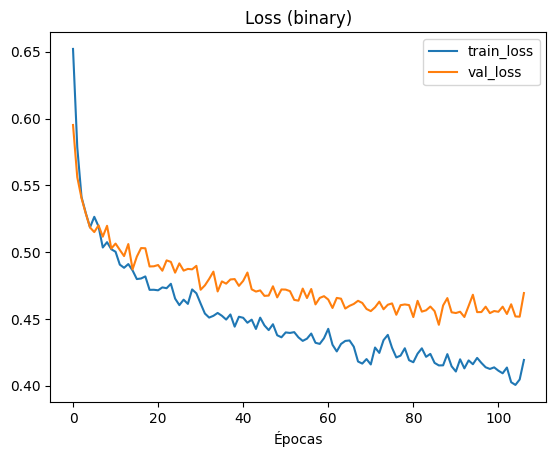

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[Binary] Confusion Matrix (0.5):
 [[581 187]
 [ 38 174]]

[Binary] Classification Report (0.5):
               precision    recall  f1-score   support

           0      0.939     0.757     0.838       768
           1      0.482     0.821     0.607       212

    accuracy                          0.770       980
   macro avg      0.710     0.789     0.723       980
weighted avg      0.840     0.770     0.788       980

[Binary] AUC ROC: 0.8529260023584905


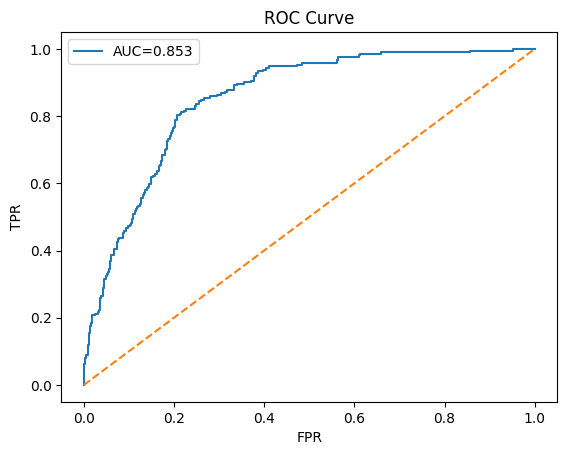

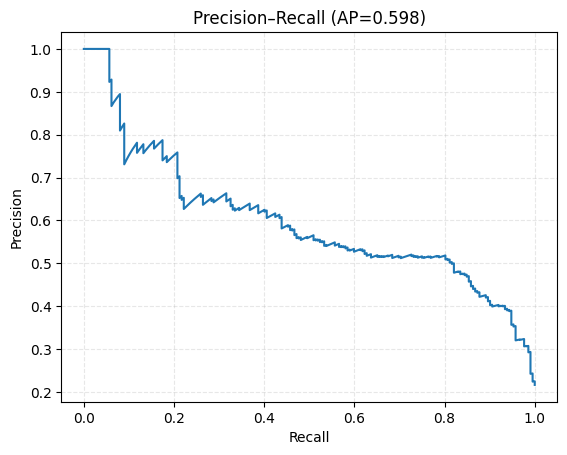

[Binary] Threshold ótimo (F1+): 0.549 | F1_max=0.630

[Binary] Confusion Matrix (thr ótimo):
 [[609 159]
 [ 42 170]]

[Binary] Classification Report (thr ótimo):
               precision    recall  f1-score   support

           0      0.935     0.793     0.858       768
           1      0.517     0.802     0.628       212

    accuracy                          0.795       980
   macro avg      0.726     0.797     0.743       980
weighted avg      0.845     0.795     0.809       980


Ficheiros: wine_model_binary.keras, scaler.pkl, predictions_binary.csv, model_meta.json
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1: AUC=0.851 | AP=0.591 | F1@0.5=0.564 | F1@opt=0.598 @thr≈0.661
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2: AUC=0.882 | AP=0.679 | F1@0.5=0.610 | F1@opt=0.633 @thr≈0.629
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3: AUC=0.843 | AP=0.569 | F1@0.5=0.596 | F1@opt=0.601 @thr≈0.487
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 4: AUC=0.847 | AP=0.588 | F1@0.5=0.581 | F1@opt=0.

In [8]:
# ============================================
# 1) FLAGS
# ============================================
TASK_TYPE = 'binary'      # 'binary' | 'multiclass' | 'regression'
DATASET   = 'white'         # 'red' | 'white'

# ============================================
# 2) Imports & seeds
# ============================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, average_precision_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import joblib

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 3) Download automático do dataset UCI
# ============================================
LOCAL   = f'/content/winequality-{DATASET}.csv'
UCI_URL = f'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{DATASET}.csv'
if not os.path.exists(LOCAL):
    !wget -q -O "$LOCAL" "$UCI_URL"

df = pd.read_csv(LOCAL, sep=';')
print("Lido:", LOCAL, "| shape:", df.shape)

# ============================================
# 4) Preparação do alvo conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    # alvo: qualidade >=7
    df['target'] = (df['quality'] >= 7).astype(int)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    print(f"[BINARY] Positivos: {int(y.sum())} | Negativos: {int((y==0).sum())}")
elif TASK_TYPE == 'multiclass':
    # alvo 3 classes: ≤5, 6, ≥7
    def to_bucket(q):
        if q <= 5: return 0
        if q == 6: return 1
        return 2
    df['target'] = df['quality'].apply(to_bucket)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    classes, counts = np.unique(y, return_counts=True)
    print(f"[MULTICLASS] Dist: {dict(zip(classes, counts))}  (0=≤5, 1=6, 2=≥7)")
elif TASK_TYPE == 'regression':
    y = df['quality'].values.astype(float)
    X = df.drop(columns=['quality']).values
    print(f"[REGRESSION] y range: {y.min()}..{y.max()}")
else:
    raise ValueError("TASK_TYPE inválido")

# Split (hold-out)
test_size = 0.40
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=test_size, random_state=42,
    stratify=y if TASK_TYPE != 'regression' else None
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42,
    stratify=y_temp if TASK_TYPE != 'regression' else None
)

# Baseline
if TASK_TYPE in ['binary','multiclass']:
    base = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
    print(f"Baseline acc: {base.score(X_test, y_test):.3f}")
else:
    base = DummyRegressor(strategy="mean").fit(X_train, y_train)
    yb = base.predict(X_test)
    print(f"Baseline RMSE (mean): {mean_squared_error(y_test, yb, squared=False):.3f}")

# Normalização
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Class weights (para classificações)
CLASS_WEIGHTS = None
if TASK_TYPE in ['binary','multiclass']:
    classes = np.unique(y_train)
    cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_vals)}
    print("Class weights:", CLASS_WEIGHTS)

# ============================================
# 5) Model builders
# ============================================
def build_binary_model(input_dim, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return m

def build_multiclass_model(input_dim, n_classes=3, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_regression_model(input_dim, l2=1e-4, drop=0.10, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='mse',
              metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return m

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ============================================
# 6) Treinar conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    model = build_binary_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (binary): {len(hist.history['loss'])}")
elif TASK_TYPE == 'multiclass':
    model = build_multiclass_model(X_train.shape[1], n_classes=len(np.unique(y)))
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (multi): {len(hist.history['loss'])}")
else:
    model = build_regression_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64, callbacks=[early_stop], verbose=0)
    print(f"Épocas (reg): {len(hist.history['loss'])}")

# Curvas de treino (loss)
plt.figure()
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title(f'Loss ({TASK_TYPE})'); plt.xlabel('Épocas'); plt.legend(); plt.show()

# ============================================
# 7) Avaliação por modo
# ============================================
feature_names = df.drop(columns=['quality'] + (['target'] if 'target' in df.columns else [])).columns.tolist()

if TASK_TYPE == 'binary':
    probs = model.predict(X_test).ravel()
    pred05 = (probs >= 0.5).astype(int)
    print("\n[Binary] Confusion Matrix (0.5):\n", confusion_matrix(y_test, pred05))
    print("\n[Binary] Classification Report (0.5):\n", classification_report(y_test, pred05, digits=3))
    print("[Binary] AUC ROC:", roc_auc_score(y_test, probs))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()

    # PR + threshold ótimo por F1(+)
    prec, rec, thr = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    f1_curve = (2*prec*rec)/(prec+rec+1e-12)
    best_idx = int(np.argmax(f1_curve))
    best_thr = thr[best_idx-1] if best_idx>0 else 0.5

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall (AP={ap:.3f})")
    plt.grid(True, ls='--', alpha=0.3); plt.show()

    print(f"[Binary] Threshold ótimo (F1+): {best_thr:.3f} | F1_max={f1_curve[best_idx]:.3f}")
    pred_opt = (probs >= best_thr).astype(int)
    print("\n[Binary] Confusion Matrix (thr ótimo):\n", confusion_matrix(y_test, pred_opt))
    print("\n[Binary] Classification Report (thr ótimo):\n", classification_report(y_test, pred_opt, digits=3))

    # Guardar artefactos + meta
    model.save('wine_model_binary.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_prob': probs,
                  'y_pred_0p5': pred05, 'y_pred_opt': pred_opt}).to_csv('predictions_binary.csv', index=False)
    meta = {"task":"binary","best_threshold":float(best_thr),"feature_names":feature_names,
            "model_path":"wine_model_binary.keras","scaler_path":"scaler.pkl",
            "dataset":{"name":f"winequality-{DATASET}","n_features":len(feature_names)}}
    with open("model_meta.json","w") as f: json.dump(meta,f,indent=2)
    print("\nFicheiros: wine_model_binary.keras, scaler.pkl, predictions_binary.csv, model_meta.json")

elif TASK_TYPE == 'multiclass':
    probs = model.predict(X_test)     # shape (n, 3)
    y_pred = probs.argmax(axis=1)
    print("\n[Multiclass] Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n[Multiclass] Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    # ROC AUC (ovo) opcional
    try:
        auc_ovr = roc_auc_score(y_test, probs, multi_class='ovr')
        print("[Multiclass] ROC AUC (OvR):", round(auc_ovr,3))
    except Exception as e:
        print("[Multiclass] ROC AUC (OvR) indisponível:", e)

    # Guardar
    model.save('wine_model_multiclass.keras')
    joblib.dump(scaler, 'scaler.pkl')
    out = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    for k in range(probs.shape[1]): out[f'p_class{k}'] = probs[:,k]
    out.to_csv('predictions_multiclass.csv', index=False)
    print("\nFicheiros: wine_model_multiclass.keras, scaler.pkl, predictions_multiclass.csv")

else:  # regression
    y_pred = model.predict(X_test).ravel()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"\n[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

    # Parity plot
    plt.figure()
    plt.scatter(y_test, y_pred, s=18, alpha=0.7)
    lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
    plt.plot(lims, lims, '--'); plt.xlim(lims); plt.ylim(lims)
    plt.xlabel('True quality'); plt.ylabel('Predicted quality'); plt.title('Parity plot'); plt.show()

    # Guardar
    model.save('wine_model_regression.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv('predictions_regression.csv', index=False)
    print("\nFicheiros: wine_model_regression.keras, scaler.pkl, predictions_regression.csv")

# ============================================
# 8) (Opcional) K-Fold apenas para 'binary' (robustez)
# ============================================
def kfold_binary(X_all, y_all, k=5, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    aucs, aps, f1_05, f1_opt = [], [], [], []
    for fold, (tr, te) in enumerate(skf.split(X_all, y_all), 1):
        X_tr, X_te = X_all[tr], X_all[te]; y_tr, y_te = y_all[tr], y_all[te]
        sc = StandardScaler().fit(X_tr)
        X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)
        classes = np.unique(y_tr)
        cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
        cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
        m = build_binary_model(X_tr.shape[1])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
              class_weight=cw, callbacks=[es], verbose=0)
        p = m.predict(X_te).ravel()
        yhat05 = (p>=0.5).astype(int)
        aucs.append(roc_auc_score(y_te, p))
        aps.append(average_precision_score(y_te, p))
        prec, rec, thr = precision_recall_curve(y_te, p)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (p>=thr_opt).astype(int)
        f1_05.append(f1_score(y_te, yhat05, pos_label=1))
        f1_opt.append(f1_score(y_te, yhat_opt, pos_label=1))
        print(f"Fold {fold}: AUC={aucs[-1]:.3f} | AP={aps[-1]:.3f} | F1@0.5={f1_05[-1]:.3f} | F1@opt={f1_opt[-1]:.3f} @thr≈{thr_opt:.3f}")
    s=lambda v: f"{np.mean(v):.3f} ± {np.std(v):.3f}"
    print("\n== K-Fold Binary (média ± dp) ==")
    print("AUC ROC :", s(aucs))
    print("AUC-PR  :", s(aps))
    print("F1 @0.5 :", s(f1_05))
    print("F1 @opt :", s(f1_opt))

# Para correr K-Fold
if TASK_TYPE == 'binary':
     X_all = df.drop(columns=['quality','target']).values
     y_all = df['target'].values
     kfold_binary(X_all, y_all, k=5)

# ============================================================
# 9) EXTRA: SMOTE + Comparativos + Repeated K-Fold (5×3)  [BINARY ONLY]
# ============================================================
if TASK_TYPE != 'binary':
    print("\n[Extra SMOTE/Comparativos/Repeated K-Fold] — ignorado (TASK_TYPE != 'binary').")
else:
    # ---------- Setup & utils ----------
    from sklearn.metrics import (classification_report, roc_auc_score,
                                 average_precision_score, precision_recall_curve, f1_score)
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.preprocessing import StandardScaler

    try:
        from imblearn.over_sampling import SMOTE
    except Exception:
        !pip install -q imbalanced-learn
        from imblearn.over_sampling import SMOTE

    def summarize_binary(y_true, probs, name="Model"):
        """AUC, AP, F1@0.5, F1@opt."""
        auc_roc = roc_auc_score(y_true, probs)
        ap      = average_precision_score(y_true, probs)
        yhat05  = (probs >= 0.5).astype(int)
        prec, rec, thr = precision_recall_curve(y_true, probs)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (probs >= thr_opt).astype(int)
        f1_05  = f1_score(y_true, yhat05,  pos_label=1)
        f1_opt = f1_score(y_true, yhat_opt, pos_label=1)
        print(f"\n== {name} ==")
        print(f"AUC ROC : {auc_roc:.3f}")
        print(f"AUC-PR  : {ap:.3f}")
        print(f"F1 @0.5 : {f1_05:.3f}")
        print(f"F1 @opt : {f1_opt:.3f}  @thr≈{thr_opt:.3f}")
        return {"auc":auc_roc, "ap":ap, "f1_05":f1_05, "f1_opt":f1_opt, "thr_opt":thr_opt}

    # 1) MLP com SMOTE (oversampling só no treino)
    sm = SMOTE(random_state=42)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)
    model_smote = build_binary_model(X_tr_sm.shape[1])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history_sm = model_smote.fit(
        X_tr_sm, y_tr_sm, validation_data=(X_val, y_val),
        epochs=300, batch_size=64, callbacks=[es], verbose=0
    )
    probs_sm = model_smote.predict(X_test).ravel()
    _ = summarize_binary(y_test, probs_sm, name="MLP (SMOTE)")

    # 2) Clássicos: Logistic Regression & Random Forest
    # (a) Com class_weight='balanced'
    logit_w = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
    rf_w    = RandomForestClassifier(n_estimators=400, random_state=42,
                                     class_weight='balanced_subsample', n_jobs=-1)
    logit_w.fit(X_train, y_train)
    rf_w.fit(X_train, y_train)
    p_logit_w = logit_w.predict_proba(X_test)[:,1]
    p_rf_w    = rf_w.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_w, name="LogReg (class_weight)")
    _ = summarize_binary(y_test, p_rf_w,    name="RandomForest (class_weight)")

    # (b) SMOTE nos clássicos
    X_tr_sm2, y_tr_sm2 = sm.fit_resample(X_train, y_train)
    logit_sm = LogisticRegression(max_iter=2000, solver='liblinear')
    rf_sm    = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    logit_sm.fit(X_tr_sm2, y_tr_sm2)
    rf_sm.fit(X_tr_sm2, y_tr_sm2)
    p_logit_sm = logit_sm.predict_proba(X_test)[:,1]
    p_rf_sm    = rf_sm.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_sm, name="LogReg (SMOTE)")
    _ = summarize_binary(y_test, p_rf_sm,    name="RandomForest (SMOTE)")

    # 3) Repeated Stratified K-Fold (5×3) — MLP vs LogReg vs RF (com e sem SMOTE)
    def repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42):
        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
        stats = {"MLP": {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "LogReg":{"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "RF":    {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]}}
        for fold, (tr, te) in enumerate(rskf.split(X_all, y_all), 1):
            X_tr, X_te = X_all[tr], X_all[te];  y_tr, y_te = y_all[tr], y_all[te]
            sc = StandardScaler().fit(X_tr)
            X_tr = sc.transform(X_tr); X_te = sc.transform(X_te)
            if use_smote:
                X_tr, y_tr = SMOTE(random_state=seed).fit_resample(X_tr, y_tr)
                cw = None
                logit = LogisticRegression(max_iter=2000, solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed, n_jobs=-1)
            else:
                classes = np.unique(y_tr)
                cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
                cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
                logit = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed,
                                               class_weight='balanced_subsample', n_jobs=-1)
            # MLP
            m = build_binary_model(X_tr.shape[1])
            es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
                  class_weight=cw, callbacks=[es], verbose=0)
            p_m = m.predict(X_te).ravel()
            # LogReg
            logit.fit(X_tr, y_tr); p_l = logit.predict_proba(X_te)[:,1]
            # RF
            rf.fit(X_tr, y_tr);    p_r = rf.predict_proba(X_te)[:,1]

            def add_stats(name, probs):
                auc_  = roc_auc_score(y_te, probs)
                ap_   = average_precision_score(y_te, probs)
                y05   = (probs>=0.5).astype(int)
                prec, rec, thr = precision_recall_curve(y_te, probs)
                f1c = (2*prec*rec)/(prec+rec+1e-12)
                idx = int(np.argmax(f1c))
                thr_opt = thr[idx-1] if idx>0 else 0.5
                yopt = (probs>=thr_opt).astype(int)
                stats[name]["auc"].append(auc_)
                stats[name]["ap"].append(ap_)
                stats[name]["f1_05"].append(f1_score(y_te, y05,  pos_label=1))
                stats[name]["f1_opt"].append(f1_score(y_te, yopt, pos_label=1))
            add_stats("MLP", p_m); add_stats("LogReg", p_l); add_stats("RF", p_r)

        def s(v): return f"{np.mean(v):.3f} ± {np.std(v):.3f}"
        print("\n" + ("="*64))
        print("Repeated Stratified K-Fold " + ("(SMOTE on train)" if use_smote else "(class_weight)"))
        print("="*64)
        for name in ["MLP","LogReg","RF"]:
            print(f"\n[{name}]  AUC={s(stats[name]['auc'])} | AP={s(stats[name]['ap'])} | "
                  f"F1@0.5={s(stats[name]['f1_05'])} | F1@opt={s(stats[name]['f1_opt'])}")
        return stats

    X_all = df.drop(columns=['quality','target']).values
    y_all = df['target'].values
    stats_weights = repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42)
    stats_smote   = repeated_cv_binary(X_all, y_all, use_smote=True,  n_splits=5, n_repeats=3, seed=42)

    print("\n✅ Fim dos comparativos: tens MLP (normal/SMOTE), LogReg e RF — com e sem SMOTE — "
          "avaliados em Hold-out e em Repeated K-Fold (média ± dp).")


Lido: /content/winequality-white.csv | shape: (4898, 12)
[MULTICLASS] Dist: {np.int64(0): np.int64(1640), np.int64(1): np.int64(2198), np.int64(2): np.int64(1060)}  (0=≤5, 1=6, 2=≥7)
Baseline acc: 0.449
Class weights: {0: 0.9952574525745257, 1: 0.7430450177035913, 2: 1.539832285115304}
Épocas (multi): 148


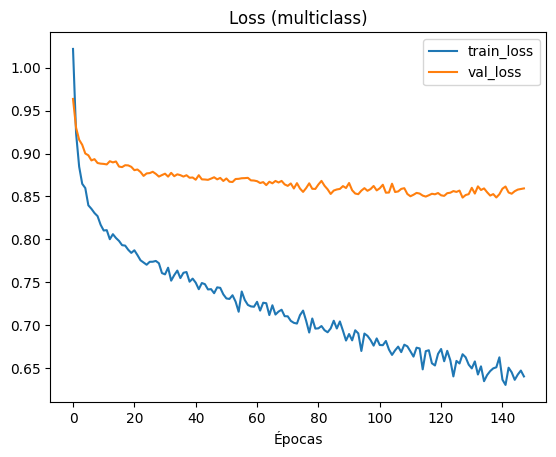

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[Multiclass] Confusion Matrix:
 [[227  82  19]
 [114 224 102]
 [  7  60 145]]

[Multiclass] Classification Report:
               precision    recall  f1-score   support

           0      0.652     0.692     0.672       328
           1      0.612     0.509     0.556       440
           2      0.545     0.684     0.607       212

    accuracy                          0.608       980
   macro avg      0.603     0.628     0.611       980
weighted avg      0.611     0.608     0.606       980

[Multiclass] ROC AUC (OvR): 0.802

Ficheiros: wine_model_multiclass.keras, scaler.pkl, predictions_multiclass.csv

[Extra SMOTE/Comparativos/Repeated K-Fold] — ignorado (TASK_TYPE != 'binary').


In [9]:
# ============================================
# 1) FLAGS
# ============================================
TASK_TYPE = 'multiclass'      # 'binary' | 'multiclass' | 'regression'
DATASET   = 'white'         # 'red' | 'white'

# ============================================
# 2) Imports & seeds
# ============================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, average_precision_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import joblib

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 3) Download automático do dataset UCI
# ============================================
LOCAL   = f'/content/winequality-{DATASET}.csv'
UCI_URL = f'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{DATASET}.csv'
if not os.path.exists(LOCAL):
    !wget -q -O "$LOCAL" "$UCI_URL"

df = pd.read_csv(LOCAL, sep=';')
print("Lido:", LOCAL, "| shape:", df.shape)

# ============================================
# 4) Preparação do alvo conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    # alvo: qualidade >=7
    df['target'] = (df['quality'] >= 7).astype(int)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    print(f"[BINARY] Positivos: {int(y.sum())} | Negativos: {int((y==0).sum())}")
elif TASK_TYPE == 'multiclass':
    # alvo 3 classes: ≤5, 6, ≥7
    def to_bucket(q):
        if q <= 5: return 0
        if q == 6: return 1
        return 2
    df['target'] = df['quality'].apply(to_bucket)
    y = df['target'].values
    X = df.drop(columns=['quality','target']).values
    classes, counts = np.unique(y, return_counts=True)
    print(f"[MULTICLASS] Dist: {dict(zip(classes, counts))}  (0=≤5, 1=6, 2=≥7)")
elif TASK_TYPE == 'regression':
    y = df['quality'].values.astype(float)
    X = df.drop(columns=['quality']).values
    print(f"[REGRESSION] y range: {y.min()}..{y.max()}")
else:
    raise ValueError("TASK_TYPE inválido")

# Split (hold-out)
test_size = 0.40
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=test_size, random_state=42,
    stratify=y if TASK_TYPE != 'regression' else None
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42,
    stratify=y_temp if TASK_TYPE != 'regression' else None
)

# Baseline
if TASK_TYPE in ['binary','multiclass']:
    base = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
    print(f"Baseline acc: {base.score(X_test, y_test):.3f}")
else:
    base = DummyRegressor(strategy="mean").fit(X_train, y_train)
    yb = base.predict(X_test)
    print(f"Baseline RMSE (mean): {mean_squared_error(y_test, yb, squared=False):.3f}")

# Normalização
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Class weights (para classificações)
CLASS_WEIGHTS = None
if TASK_TYPE in ['binary','multiclass']:
    classes = np.unique(y_train)
    cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_vals)}
    print("Class weights:", CLASS_WEIGHTS)

# ============================================
# 5) Model builders
# ============================================
def build_binary_model(input_dim, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return m

def build_multiclass_model(input_dim, n_classes=3, l2=1e-4, drop1=0.30, drop2=0.20, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop1),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop2),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_regression_model(input_dim, l2=1e-4, drop=0.10, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='mse',
              metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return m

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ============================================
# 6) Treinar conforme TASK_TYPE
# ============================================
if TASK_TYPE == 'binary':
    model = build_binary_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (binary): {len(hist.history['loss'])}")
elif TASK_TYPE == 'multiclass':
    model = build_multiclass_model(X_train.shape[1], n_classes=len(np.unique(y)))
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64,
                     class_weight=CLASS_WEIGHTS, callbacks=[early_stop], verbose=0)
    print(f"Épocas (multi): {len(hist.history['loss'])}")
else:
    model = build_regression_model(X_train.shape[1])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=300, batch_size=64, callbacks=[early_stop], verbose=0)
    print(f"Épocas (reg): {len(hist.history['loss'])}")

# Curvas de treino (loss)
plt.figure()
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title(f'Loss ({TASK_TYPE})'); plt.xlabel('Épocas'); plt.legend(); plt.show()

# ============================================
# 7) Avaliação por modo
# ============================================
feature_names = df.drop(columns=['quality'] + (['target'] if 'target' in df.columns else [])).columns.tolist()

if TASK_TYPE == 'binary':
    probs = model.predict(X_test).ravel()
    pred05 = (probs >= 0.5).astype(int)
    print("\n[Binary] Confusion Matrix (0.5):\n", confusion_matrix(y_test, pred05))
    print("\n[Binary] Classification Report (0.5):\n", classification_report(y_test, pred05, digits=3))
    print("[Binary] AUC ROC:", roc_auc_score(y_test, probs))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()

    # PR + threshold ótimo por F1(+)
    prec, rec, thr = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    f1_curve = (2*prec*rec)/(prec+rec+1e-12)
    best_idx = int(np.argmax(f1_curve))
    best_thr = thr[best_idx-1] if best_idx>0 else 0.5

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall (AP={ap:.3f})")
    plt.grid(True, ls='--', alpha=0.3); plt.show()

    print(f"[Binary] Threshold ótimo (F1+): {best_thr:.3f} | F1_max={f1_curve[best_idx]:.3f}")
    pred_opt = (probs >= best_thr).astype(int)
    print("\n[Binary] Confusion Matrix (thr ótimo):\n", confusion_matrix(y_test, pred_opt))
    print("\n[Binary] Classification Report (thr ótimo):\n", classification_report(y_test, pred_opt, digits=3))

    # Guardar artefactos + meta
    model.save('wine_model_binary.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_prob': probs,
                  'y_pred_0p5': pred05, 'y_pred_opt': pred_opt}).to_csv('predictions_binary.csv', index=False)
    meta = {"task":"binary","best_threshold":float(best_thr),"feature_names":feature_names,
            "model_path":"wine_model_binary.keras","scaler_path":"scaler.pkl",
            "dataset":{"name":f"winequality-{DATASET}","n_features":len(feature_names)}}
    with open("model_meta.json","w") as f: json.dump(meta,f,indent=2)
    print("\nFicheiros: wine_model_binary.keras, scaler.pkl, predictions_binary.csv, model_meta.json")

elif TASK_TYPE == 'multiclass':
    probs = model.predict(X_test)     # shape (n, 3)
    y_pred = probs.argmax(axis=1)
    print("\n[Multiclass] Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n[Multiclass] Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    # ROC AUC (ovo) opcional
    try:
        auc_ovr = roc_auc_score(y_test, probs, multi_class='ovr')
        print("[Multiclass] ROC AUC (OvR):", round(auc_ovr,3))
    except Exception as e:
        print("[Multiclass] ROC AUC (OvR) indisponível:", e)

    # Guardar
    model.save('wine_model_multiclass.keras')
    joblib.dump(scaler, 'scaler.pkl')
    out = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    for k in range(probs.shape[1]): out[f'p_class{k}'] = probs[:,k]
    out.to_csv('predictions_multiclass.csv', index=False)
    print("\nFicheiros: wine_model_multiclass.keras, scaler.pkl, predictions_multiclass.csv")

else:  # regression
    y_pred = model.predict(X_test).ravel()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"\n[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

    # Parity plot
    plt.figure()
    plt.scatter(y_test, y_pred, s=18, alpha=0.7)
    lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
    plt.plot(lims, lims, '--'); plt.xlim(lims); plt.ylim(lims)
    plt.xlabel('True quality'); plt.ylabel('Predicted quality'); plt.title('Parity plot'); plt.show()

    # Guardar
    model.save('wine_model_regression.keras')
    joblib.dump(scaler, 'scaler.pkl')
    pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv('predictions_regression.csv', index=False)
    print("\nFicheiros: wine_model_regression.keras, scaler.pkl, predictions_regression.csv")

# ============================================
# 8) (Opcional) K-Fold apenas para 'binary' (robustez)
# ============================================
def kfold_binary(X_all, y_all, k=5, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    aucs, aps, f1_05, f1_opt = [], [], [], []
    for fold, (tr, te) in enumerate(skf.split(X_all, y_all), 1):
        X_tr, X_te = X_all[tr], X_all[te]; y_tr, y_te = y_all[tr], y_all[te]
        sc = StandardScaler().fit(X_tr)
        X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)
        classes = np.unique(y_tr)
        cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
        cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
        m = build_binary_model(X_tr.shape[1])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
              class_weight=cw, callbacks=[es], verbose=0)
        p = m.predict(X_te).ravel()
        yhat05 = (p>=0.5).astype(int)
        aucs.append(roc_auc_score(y_te, p))
        aps.append(average_precision_score(y_te, p))
        prec, rec, thr = precision_recall_curve(y_te, p)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (p>=thr_opt).astype(int)
        f1_05.append(f1_score(y_te, yhat05, pos_label=1))
        f1_opt.append(f1_score(y_te, yhat_opt, pos_label=1))
        print(f"Fold {fold}: AUC={aucs[-1]:.3f} | AP={aps[-1]:.3f} | F1@0.5={f1_05[-1]:.3f} | F1@opt={f1_opt[-1]:.3f} @thr≈{thr_opt:.3f}")
    s=lambda v: f"{np.mean(v):.3f} ± {np.std(v):.3f}"
    print("\n== K-Fold Binary (média ± dp) ==")
    print("AUC ROC :", s(aucs))
    print("AUC-PR  :", s(aps))
    print("F1 @0.5 :", s(f1_05))
    print("F1 @opt :", s(f1_opt))

# Para correr K-Fold
if TASK_TYPE == 'binary':
     X_all = df.drop(columns=['quality','target']).values
     y_all = df['target'].values
     kfold_binary(X_all, y_all, k=5)

# ============================================================
# 9) EXTRA: SMOTE + Comparativos + Repeated K-Fold (5×3)  [BINARY ONLY]
# ============================================================
if TASK_TYPE != 'binary':
    print("\n[Extra SMOTE/Comparativos/Repeated K-Fold] — ignorado (TASK_TYPE != 'binary').")
else:
    # ---------- Setup & utils ----------
    from sklearn.metrics import (classification_report, roc_auc_score,
                                 average_precision_score, precision_recall_curve, f1_score)
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.preprocessing import StandardScaler

    try:
        from imblearn.over_sampling import SMOTE
    except Exception:
        !pip install -q imbalanced-learn
        from imblearn.over_sampling import SMOTE

    def summarize_binary(y_true, probs, name="Model"):
        """AUC, AP, F1@0.5, F1@opt."""
        auc_roc = roc_auc_score(y_true, probs)
        ap      = average_precision_score(y_true, probs)
        yhat05  = (probs >= 0.5).astype(int)
        prec, rec, thr = precision_recall_curve(y_true, probs)
        f1c = (2*prec*rec)/(prec+rec+1e-12)
        idx = int(np.argmax(f1c))
        thr_opt = thr[idx-1] if idx>0 else 0.5
        yhat_opt = (probs >= thr_opt).astype(int)
        f1_05  = f1_score(y_true, yhat05,  pos_label=1)
        f1_opt = f1_score(y_true, yhat_opt, pos_label=1)
        print(f"\n== {name} ==")
        print(f"AUC ROC : {auc_roc:.3f}")
        print(f"AUC-PR  : {ap:.3f}")
        print(f"F1 @0.5 : {f1_05:.3f}")
        print(f"F1 @opt : {f1_opt:.3f}  @thr≈{thr_opt:.3f}")
        return {"auc":auc_roc, "ap":ap, "f1_05":f1_05, "f1_opt":f1_opt, "thr_opt":thr_opt}

    # 1) MLP com SMOTE (oversampling só no treino)
    sm = SMOTE(random_state=42)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)
    model_smote = build_binary_model(X_tr_sm.shape[1])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history_sm = model_smote.fit(
        X_tr_sm, y_tr_sm, validation_data=(X_val, y_val),
        epochs=300, batch_size=64, callbacks=[es], verbose=0
    )
    probs_sm = model_smote.predict(X_test).ravel()
    _ = summarize_binary(y_test, probs_sm, name="MLP (SMOTE)")

    # 2) Clássicos: Logistic Regression & Random Forest
    # (a) Com class_weight='balanced'
    logit_w = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
    rf_w    = RandomForestClassifier(n_estimators=400, random_state=42,
                                     class_weight='balanced_subsample', n_jobs=-1)
    logit_w.fit(X_train, y_train)
    rf_w.fit(X_train, y_train)
    p_logit_w = logit_w.predict_proba(X_test)[:,1]
    p_rf_w    = rf_w.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_w, name="LogReg (class_weight)")
    _ = summarize_binary(y_test, p_rf_w,    name="RandomForest (class_weight)")

    # (b) SMOTE nos clássicos
    X_tr_sm2, y_tr_sm2 = sm.fit_resample(X_train, y_train)
    logit_sm = LogisticRegression(max_iter=2000, solver='liblinear')
    rf_sm    = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    logit_sm.fit(X_tr_sm2, y_tr_sm2)
    rf_sm.fit(X_tr_sm2, y_tr_sm2)
    p_logit_sm = logit_sm.predict_proba(X_test)[:,1]
    p_rf_sm    = rf_sm.predict_proba(X_test)[:,1]
    _ = summarize_binary(y_test, p_logit_sm, name="LogReg (SMOTE)")
    _ = summarize_binary(y_test, p_rf_sm,    name="RandomForest (SMOTE)")

    # 3) Repeated Stratified K-Fold (5×3) — MLP vs LogReg vs RF (com e sem SMOTE)
    def repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42):
        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
        stats = {"MLP": {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "LogReg":{"auc":[], "ap":[], "f1_05":[], "f1_opt":[]},
                 "RF":    {"auc":[], "ap":[], "f1_05":[], "f1_opt":[]}}
        for fold, (tr, te) in enumerate(rskf.split(X_all, y_all), 1):
            X_tr, X_te = X_all[tr], X_all[te];  y_tr, y_te = y_all[tr], y_all[te]
            sc = StandardScaler().fit(X_tr)
            X_tr = sc.transform(X_tr); X_te = sc.transform(X_te)
            if use_smote:
                X_tr, y_tr = SMOTE(random_state=seed).fit_resample(X_tr, y_tr)
                cw = None
                logit = LogisticRegression(max_iter=2000, solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed, n_jobs=-1)
            else:
                classes = np.unique(y_tr)
                cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
                cw = {int(c): float(w) for c, w in zip(classes, cw_vals)}
                logit = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
                rf    = RandomForestClassifier(n_estimators=300, random_state=seed,
                                               class_weight='balanced_subsample', n_jobs=-1)
            # MLP
            m = build_binary_model(X_tr.shape[1])
            es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
                  class_weight=cw, callbacks=[es], verbose=0)
            p_m = m.predict(X_te).ravel()
            # LogReg
            logit.fit(X_tr, y_tr); p_l = logit.predict_proba(X_te)[:,1]
            # RF
            rf.fit(X_tr, y_tr);    p_r = rf.predict_proba(X_te)[:,1]

            def add_stats(name, probs):
                auc_  = roc_auc_score(y_te, probs)
                ap_   = average_precision_score(y_te, probs)
                y05   = (probs>=0.5).astype(int)
                prec, rec, thr = precision_recall_curve(y_te, probs)
                f1c = (2*prec*rec)/(prec+rec+1e-12)
                idx = int(np.argmax(f1c))
                thr_opt = thr[idx-1] if idx>0 else 0.5
                yopt = (probs>=thr_opt).astype(int)
                stats[name]["auc"].append(auc_)
                stats[name]["ap"].append(ap_)
                stats[name]["f1_05"].append(f1_score(y_te, y05,  pos_label=1))
                stats[name]["f1_opt"].append(f1_score(y_te, yopt, pos_label=1))
            add_stats("MLP", p_m); add_stats("LogReg", p_l); add_stats("RF", p_r)

        def s(v): return f"{np.mean(v):.3f} ± {np.std(v):.3f}"
        print("\n" + ("="*64))
        print("Repeated Stratified K-Fold " + ("(SMOTE on train)" if use_smote else "(class_weight)"))
        print("="*64)
        for name in ["MLP","LogReg","RF"]:
            print(f"\n[{name}]  AUC={s(stats[name]['auc'])} | AP={s(stats[name]['ap'])} | "
                  f"F1@0.5={s(stats[name]['f1_05'])} | F1@opt={s(stats[name]['f1_opt'])}")
        return stats

    X_all = df.drop(columns=['quality','target']).values
    y_all = df['target'].values
    stats_weights = repeated_cv_binary(X_all, y_all, use_smote=False, n_splits=5, n_repeats=3, seed=42)
    stats_smote   = repeated_cv_binary(X_all, y_all, use_smote=True,  n_splits=5, n_repeats=3, seed=42)

    print("\n✅ Fim dos comparativos: tens MLP (normal/SMOTE), LogReg e RF — com e sem SMOTE — "
          "avaliados em Hold-out e em Repeated K-Fold (média ± dp).")

Lido: /content/winequality-white.csv | shape: (4898, 12)
[REGRESSION] y range: 3.0..9.0
Baseline RMSE (mean): 0.863
Épocas (reg): 66


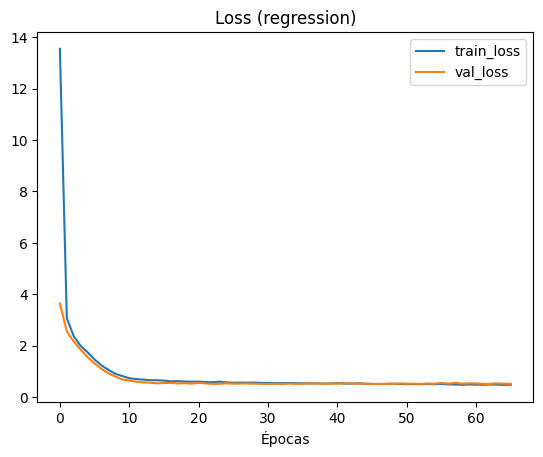

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

[Regression] RMSE=0.689 | MAE=0.535 | R²=0.361


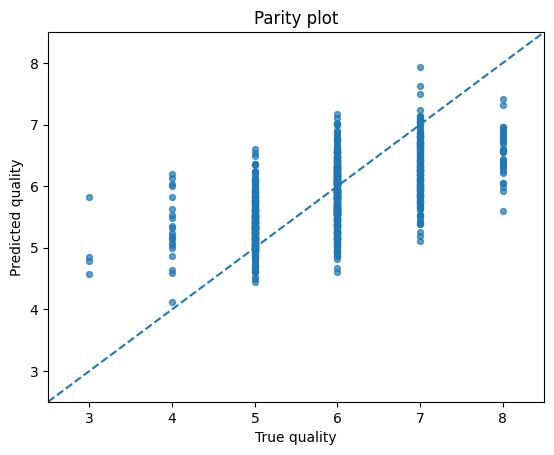

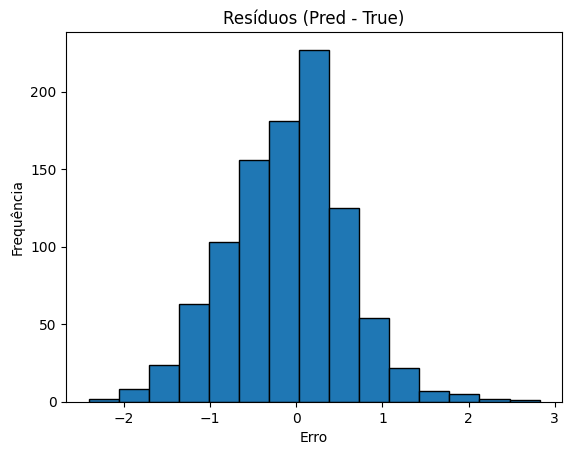


Ficheiros: wine_model_regression_white.keras, scaler_regression_white.pkl, predictions_regression_white.csv


In [10]:
# ============================================
# 0) FLAGS
# ============================================
TASK_TYPE = 'regression'    # 'binary' | 'multiclass' | 'regression'
DATASET   = 'white'           # 'red'| 'white'

# ============================================
# 1) Imports & seeds
# ============================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import joblib

np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 2) Download automático do dataset UCI
# ============================================
LOCAL   = f'/content/winequality-{DATASET}.csv'
UCI_URL = f'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-{DATASET}.csv'
if not os.path.exists(LOCAL):
    !wget -q -O "$LOCAL" "$UCI_URL"

df = pd.read_csv(LOCAL, sep=';')
print("Lido:", LOCAL, "| shape:", df.shape)

# ============================================
# 3) Preparação (REGRESSÃO)
# ============================================
y = df['quality'].values.astype(float)
X = df.drop(columns=['quality']).values
print(f"[REGRESSION] y range: {y.min()}..{y.max()}")

# Split Hold-out (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Baseline (RMSE = sqrt(MSE) — compatível com qualquer versão do sklearn)
base = DummyRegressor(strategy="mean").fit(X_train, y_train)
yb = base.predict(X_test)
rmse_base = (mean_squared_error(y_test, yb)) ** 0.5
print(f"Baseline RMSE (mean): {rmse_base:.3f}")

# Normalização
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ============================================
# 4) Modelo de Regressão (MLP)
# ============================================
def build_regression_model(input_dim, l2=1e-4, drop=0.10, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(drop),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='linear')
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return m

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model = build_regression_model(X_train.shape[1])

# ============================================
# 5) Treino
# ============================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300, batch_size=64,
    callbacks=[early_stop], verbose=0
)
print(f"Épocas (reg): {len(history.history['loss'])}")

# Curva de loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss (regression)'); plt.xlabel('Épocas'); plt.legend(); plt.show()

# ============================================
# 6) Avaliação — Hold-out
# ============================================
y_pred = model.predict(X_test).ravel()
mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5                  # <- sem squared=False
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"\n[Regression] RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

# Parity plot
plt.figure()
plt.scatter(y_test, y_pred, s=18, alpha=0.7)
lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
plt.plot(lims, lims, '--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel('True quality'); plt.ylabel('Predicted quality'); plt.title('Parity plot'); plt.show()

# Histograma de resíduos
resid = y_pred - y_test
plt.figure()
plt.hist(resid, bins=15, edgecolor='k')
plt.title('Resíduos (Pred - True)'); plt.xlabel('Erro'); plt.ylabel('Frequência')
plt.show()

# ============================================
# 7) Guardar artefactos
# ============================================
model.save(f'wine_model_regression_{DATASET}.keras')
joblib.dump(scaler, f'scaler_regression_{DATASET}.pkl')
pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).to_csv(f'predictions_regression_{DATASET}.csv', index=False)
print(f"\nFicheiros: wine_model_regression_{DATASET}.keras, scaler_regression_{DATASET}.pkl, predictions_regression_{DATASET}.csv")

# ============================================
# 8) (Opcional) K-Fold para Regressão (k=5) — imprime média ± dp
# ============================================
def kfold_regression(X_all, y_all, k=5, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmses, maes, r2s = [], [], []
    for fold, (tr, te) in enumerate(kf.split(X_all), 1):
        X_tr, X_te = X_all[tr], X_all[te]
        y_tr, y_te = y_all[tr], y_all[te]
        sc = StandardScaler().fit(X_tr)
        X_tr, X_te = sc.transform(X_tr), sc.transform(X_te)
        m = build_regression_model(X_tr.shape[1])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
        m.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=64,
              callbacks=[es], verbose=0)
        p = m.predict(X_te).ravel()
        mse  = mean_squared_error(y_te, p)
        rmse = mse ** 0.5
        mae  = mean_absolute_error(y_te, p)
        r2   = r2_score(y_te, p)
        rmses.append(rmse); maes.append(mae); r2s.append(r2)
        print(f"Fold {fold}: RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")
    s = lambda v: (np.mean(v), np.std(v))
    m_rmse, d_rmse = s(rmses); m_mae, d_mae = s(maes); m_r2, d_r2 = s(r2s)
    print("\n== K-Fold Regressão (média ± dp) ==")
    print(f"RMSE : {m_rmse:.3f} ± {d_rmse:.3f}")
    print(f"MAE  : {m_mae:.3f} ± {d_mae:.3f}")
    print(f"R²   : {m_r2:.3f} ± {d_r2:.3f}")

# Descomenta para correr K-Fold agora (pode levar alguns minutos):
# kfold_regression(X, y, k=5)
